# Bus Ridership by Neighborhood
### By Brandon Moretti

Dataset: [Pittsburgh Regional Transit Monthly Average Ridership by Route](https://data.wprdc.org/dataset/prt-monthly-average-ridership-by-route)

Here's some code that Griffin and I wrote together in order to match each of the bus routes to the neighborhoods they serve.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load in the neighborhoods
neighborhood_gpd = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter to only bus stops
stops = stops[stops['Mode'] == "Bus"]

# Our goal is to figure out which routes run through each neighborhood, so create a dataframe
neighborhoods = pd.DataFrame(columns=["Name", "Polygon", "Routes"])
neighborhoods["Name"] = neighborhood_gpd["hood"]
neighborhoods["Polygon"] = neighborhood_gpd["geometry"]
neighborhoods["Routes"] = [[] for _ in range(len(neighborhoods))]

for index, stop in stops.iterrows():
    # Create a point for the stop
    stop_point = Point(stop["Longitude"], stop["Latitude"])
    routes = stop["Routes_ser"].split(", ")
    # Loop through the neighborhoods
    for index2, neighborhood in neighborhoods.iterrows():
        if neighborhood["Polygon"].contains(stop_point):
            for route in routes:
                if route not in neighborhoods.at[index2, 'Routes']:
                    neighborhoods.at[index2, 'Routes'].append(route)
            break

neighborhoods.head(10)


,Name,Polygon,Routes
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 88, 74, 71C, 67, 69]"
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 64, 67, 69, 61A, 61B, 61C,..."
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 71A, 87, 88]"
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",[83]
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 51, 51L]"
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 71D, 74]"
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 83]"
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...",[31]
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 28X, 58, ..."
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...",[40]


In [7]:
import geopandas as gpd
import pandas as pd

# Load in the ridership
ridership = pd.read_csv('data/prt_ridership.csv')
ridership.head()


,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,avg_riders,day_count
0,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SAT.,969.50,4
1,4,004,4 - TROY HILL,Ross,Bus,2017-01-01,201701,SAT.,218.25,4
2,6,006,6 - SPRING HILL,Ross,Bus,2017-01-01,201701,SAT.,495.50,4
3,8,008,8 - PERRYSVILLE,Ross,Bus,2017-01-01,201701,SAT.,1480.00,4
4,11,011,11 - FINEVIEW,Ross,Bus,2017-01-01,201701,SAT.,208.00,4


In [12]:
## New data frame showing ridership only from the most recently recorded month
ridershipRecent = ridership[ridership["month_start"] == "2022-10-01"]
ridershipRecent.head()

,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,avg_riders,day_count
16246,1,NaN,1 - FREEPORT ROAD,Ross,Bus,2022-10-01,202210,SAT.,1181.8,5
16247,11,NaN,11 - FINEVIEW,Ross,Bus,2022-10-01,202210,SAT.,175.8,5
16248,12,NaN,12 - MCKNIGHT,Ross,Bus,2022-10-01,202210,SAT.,1235.8,5
16249,13,NaN,13 - BELLEVUE,Ross,Bus,2022-10-01,202210,SAT.,1054.4,5
16250,14,NaN,14 - OHIO VALLEY,Ross,Bus,2022-10-01,202210,SAT.,449.6,5


## Ridership
### What do we mean by this and how are we calculating it?

Ridership is how we are guaging how populated the bussing system is in each neighborhood. How this is being calculated is by first using each neighborhood's list of bus routes, these being the bus routes that simply pass through these neighborhoods. Now to clear this up, each bus route in the data set has a value for average riders on a general weekday, a saturday, and a sunday. So this calculation is not exactly the average weekly ridership of each route, but when we ultimately add these three values together, it gives us a good score for that route. 

Now back to the process, we go through each route in that list of routes that pass through the given neighborhood, come out with that "score" that I just talked about, and then it gets added to a total ridership for that neighborhood. Once the program has finished calculating the score for each route in that neighborhood, we are left with a total index for that neighborhood.

In [13]:
## New column called "ridership"
neighborhoods["Ridership"] = 0

for index, neighborhood in neighborhoods.iterrows():
    total = 0
    for route in neighborhood["Routes"]:
        for index2, row in ridershipRecent.iterrows():
            if row["route"] == route:
                total += row["avg_riders"]
        neighborhoods.at[index, "Ridership"] = total
    
neighborhoods.head()

,Name,Polygon,Routes,Ridership
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 88, 74, 71C, 67, 69]",29997.123810
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 64, 67, 69, 61A, 61B, 61C,...",68439.038095
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 71A, 87, 88]",14630.323810
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",[83],3518.885714
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 51, 51L]",19957.438095


In [16]:
neighborhoods.sort_values("Ridership")

,Name,Polygon,Routes,Ridership
18,Arlington Heights,"POLYGON ((-79.96568 40.41735, -79.96566 40.417...",[],0.000000
64,Ridgemont,"POLYGON ((-80.03431 40.43366, -80.03424 40.433...",[],0.000000
32,Allegheny West,"POLYGON ((-80.00895 40.44996, -80.00894 40.449...",[18],41.952381
82,Swisshelm Park,"POLYGON ((-79.89143 40.42685, -79.89192 40.426...","[71, P71]",303.809524
53,Banksville,"POLYGON ((-80.02969 40.42127, -80.02976 40.419...",[36],467.714286
...,...,...,...,...
77,West Oakland,"POLYGON ((-79.95744 40.44252, -79.95744 40.442...","[54, 61A, 61B, 61C, 61D, 67, 69, 71A, 71B, 71C...",107246.304762
46,Central Oakland,"POLYGON ((-79.94925 40.44135, -79.94925 40.441...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 58, 65, 2...",107355.400000
62,South Oakland,"POLYGON ((-79.95899 40.43665, -79.95887 40.436...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 58, 65, 2...",111127.361905
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 28X, 58, ...",116703.019048


<AxesSubplot: xlabel='Name'>

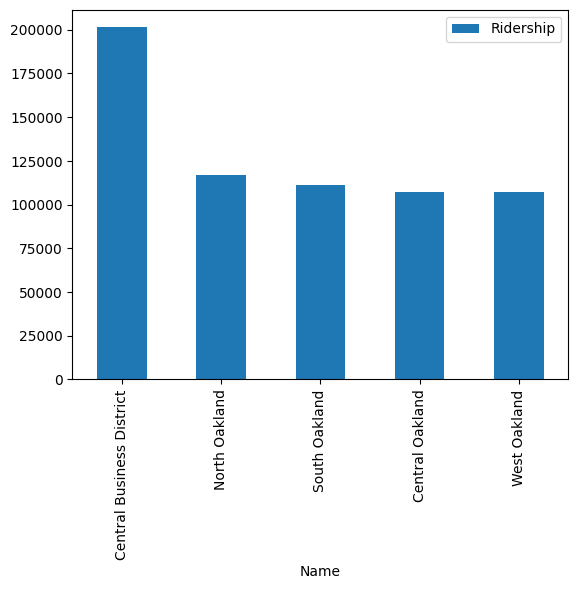

In [18]:
neighborhoods.sort_values("Ridership", ascending=False).head().plot(kind="bar", x="Name")

### Ridership Conclusion
This is not much of a surprise to me. Downtown Pittsburgh is the ideal place for bus ridership because so many bus routes go through Downtown for obvious reasons. If you want to fully rely on public transportation by the means of commanality, Downtown Pittsburgh is a no brainer. This rule applies for any other large city; a lot of people who want to depend on the plethora of options at hand for bussing are best off being right in the downtown area because there is no shortage of routes going through it. 